<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 70px">

# Client Project: Estimating Neighborhood Affluence with Yelp

<i>
                
                Submitted by Shannon Bingham and Roy Kim
</i>

 
## Problem Statement
The goal of the project is to estimate the affluence of a neighborhood based on the number of `$` of businesses and services (according to Yelp) in a given neighborhood (`$`, `$$`, `$$$`, `$$$$`). The project takes a list of zip codes as input and estimates the wealth of the locality. While traditional methods typically estimate wealth of a locality based on demographic characteristics (e.g. income or unemployment rate), the novelty of this approach is in its use of big data related to commercial activity and cost of product and services as an indicator for affluency.

## Notebook Description
_This notebook contains principal component analysis of the engineered data, in order to see relationships between features and also as a precursor for modeling._

# Principal Component Analysis

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [28]:
df = pd.read_csv('../data/composite_zip_WI.csv')

In [29]:
df.head()

,zipcode,n_business,n_d1,n_d2,n_d3,n_d4,n_review,n_s1,n_s1plus,n_s2,...,n_s_gourmet,p_s_gourmet,p_ge_s2_gourmet,p_ge_s2plus_gourmet,p_ge_s3_gourmet,p_ge_s3plus_gourmet,p_ge_s4_gourmet,p_ge_s4plus_gourmet,p_ge_s5_gourmet,score_s_gourmet
0,53004,64,26,37,0,1,1395,3,11,18,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
1,53006,8,5,3,0,0,123,0,8,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
2,53018,363,177,173,13,0,10591,30,156,243,...,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,2.5
3,53022,112,46,63,3,0,3469,0,40,291,...,1,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0,3.5
4,53024,228,94,127,6,1,7464,3,148,327,...,3,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0,10.5


In [30]:
df = df.drop(['average_agi', 'zipcode'],axis=1)

In [31]:
pca = PCA()
df_pca = pca.fit_transform(df)

In [32]:
# Examine explained variance.
var_exp = pca.explained_variance_ratio_
print('Explained variance:            ', var_exp)

# Examine cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print('Cumulative explained variance: ', cum_var_exp)

Explained variance:             [9.99368627e-01 4.03299010e-04 1.82529014e-04 3.66797476e-05
 4.20052853e-06 2.34639712e-06 1.30927752e-06 4.47530885e-07
 3.34988323e-07 6.78410356e-08 5.59217019e-08 4.10337658e-08
 1.96505022e-08 1.11883580e-08 7.56834440e-09 6.16135087e-09
 3.09957704e-09 2.75545533e-09 2.07261200e-09 1.45035763e-09
 1.13144469e-09 9.64892555e-10 6.81831973e-10 5.04747223e-10
 4.69947733e-10 4.33496022e-10 3.38140153e-10 3.17129008e-10
 2.90681204e-10 2.57157354e-10 2.38189559e-10 2.06474261e-10
 1.91644464e-10 1.68441615e-10 1.66199323e-10 1.31443074e-10
 1.18706380e-10 1.05546179e-10 9.19835311e-11 8.08824052e-11
 7.80744466e-11 6.92988115e-11 6.10600654e-11 6.07839110e-11
 5.60850933e-11 5.10500901e-11 4.77793273e-11 4.48044962e-11
 4.38899806e-11 3.77903510e-11 3.34883825e-11 3.06497477e-11
 2.83717477e-11 2.59118437e-11 2.34935230e-11 2.26737231e-11
 2.08148127e-11 1.97410787e-11 1.89583074e-11 1.53633374e-11
 1.49462158e-11 1.42003521e-11 1.28943061e-11 1.17098

We can explain 99.9% of the variance in the original data with just our first principal component. With this in mind, we can use the first principal component in our modeling at a later stage.

In [33]:
var_exp.shape

(96,)

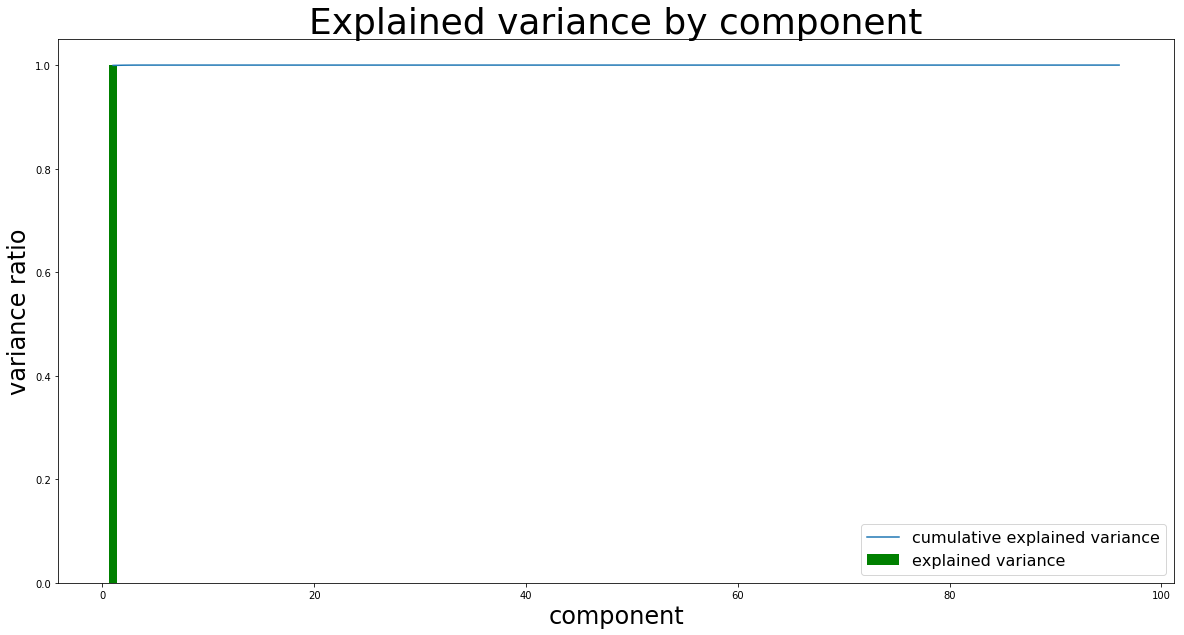

In [34]:
fig = plt.figure(figsize=(20,10))
plt.bar(np.array(range(len(var_exp)))+1, 
        var_exp, 
        color='g', 
        label='explained variance')
plt.plot(np.array(range(len(var_exp)))+1, 
         np.cumsum(var_exp), 
         label='cumulative explained variance')
plt.legend(fontsize=16)
plt.xlabel('component', fontsize=24)
plt.ylabel('variance ratio', fontsize=24)
plt.title('Explained variance by component', fontsize=36);

In [35]:
component_names = ["component_"+str(i+1) for i in range(len(var_exp))]
svd_df = pd.DataFrame(df_pca, columns=component_names)
svd_df.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_87,component_88,component_89,component_90,component_91,component_92,component_93,component_94,component_95,component_96
0,-39800.403096,116.580505,-276.865698,-77.151061,-55.615160,56.214189,-16.267303,-1.871638,2.254618,-9.372482,...,-0.124559,-0.071136,0.021684,0.012857,-0.053043,0.004412,-0.067628,-0.011723,-0.014458,7.587661e-12
1,-44782.181344,-194.205935,-353.059176,-199.271642,-62.640354,82.218920,-73.529242,-18.475520,13.864074,6.853474,...,-0.007670,0.158408,0.073416,0.006432,-0.036302,0.024216,-0.003700,0.011264,-0.005924,7.587661e-12
2,-5011.817899,400.072409,1171.357137,169.293169,-138.220218,-317.423462,15.706479,158.431870,32.974547,-6.148926,...,0.046246,-0.008715,0.023434,0.025192,-0.024763,0.019217,0.006360,0.008709,0.008029,7.587661e-12
3,-33035.798408,-75.622570,568.699875,-77.542181,171.028705,43.483008,-113.017373,33.081881,-97.875660,-4.982353,...,0.007113,-0.057504,0.041197,-0.108933,-0.026442,-0.039709,0.000838,0.011116,0.011681,7.587661e-12
4,-17661.592180,434.368194,1111.782877,-121.652633,108.818124,-136.479815,-115.235360,5.024301,-43.144977,-16.991967,...,0.052656,0.001794,-0.005681,0.022491,0.003894,-0.045229,0.001194,-0.011371,0.007936,7.587661e-12


In [36]:
# Creating a DataFrame that holds the original components as rows
# compared to the new features as columns
loadings=pd.DataFrame(pca.components_,index=component_names,columns=df.columns).T

# Creating two new columns for the absolute value of components 1 and 2
loadings['abs_component_1'] = np.abs(loadings.component_1)
loadings['abs_component_2'] = np.abs(loadings.component_2)
loadings.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_89,component_90,component_91,component_92,component_93,component_94,component_95,component_96,abs_component_1,abs_component_2
n_business,0.002765,0.001903,0.043873,0.105122,0.056823,-0.318984,0.252563,-0.061630,-0.029612,-0.122221,...,-0.119637,0.083919,-0.019048,-0.029329,-0.043298,-0.005714,0.074067,0.688052,0.002765,0.001903
n_d1,0.001259,-0.003034,0.020394,0.058405,0.038577,-0.148118,0.108182,-0.034029,0.055419,0.112385,...,0.056269,-0.060209,0.028585,0.017352,0.049784,0.004134,-0.054967,-0.462719,0.001259,0.003034
n_d2,0.001375,0.004935,0.023182,0.045816,0.020622,-0.157313,0.131684,-0.035139,-0.088251,-0.192239,...,-0.006469,-0.036906,0.046418,0.008072,0.050941,0.001076,-0.046681,-0.232196,0.001375,0.004935
n_d3,0.000109,0.000078,0.000486,0.001032,-0.003930,-0.014261,0.011240,0.006171,0.004475,-0.033446,...,-0.068221,-0.001034,0.006332,0.057054,0.057230,0.067715,-0.060812,0.019042,0.000109,0.000078
n_d4,0.000022,-0.000088,-0.000297,-0.000005,0.001672,0.000777,0.001594,0.002416,-0.001212,-0.007176,...,0.055695,0.028283,-0.038379,-0.049063,-0.082003,-0.051679,0.078531,0.169545,0.000022,0.000088


In [37]:
# Retrieving the features that explains the most variance in the first component
loadings.sort_values('abs_component_1',ascending=False).head(10)[['component_1']]

,component_1
score_s,0.958892
n_review,0.250244
n_s4,0.103382
n_s3plus,0.063951
n_s4plus,0.050544
n_s3,0.021918
n_s2plus,0.006789
score_d,0.004423
n_business,0.002765
score_s_categories,0.002475


In [38]:
# Retrieving the features that explains the most variance in the first component
loadings.sort_values('abs_component_2',ascending=False).head(10)[['component_2']]

,component_2
n_s4,-0.784719
n_s4plus,0.589657
n_s3plus,0.170379
score_s,0.054646
n_review,-0.046278
n_s2plus,-0.042140
n_s1plus,0.015166
n_s3,-0.008262
n_s5,0.007498
n_s2,0.007495


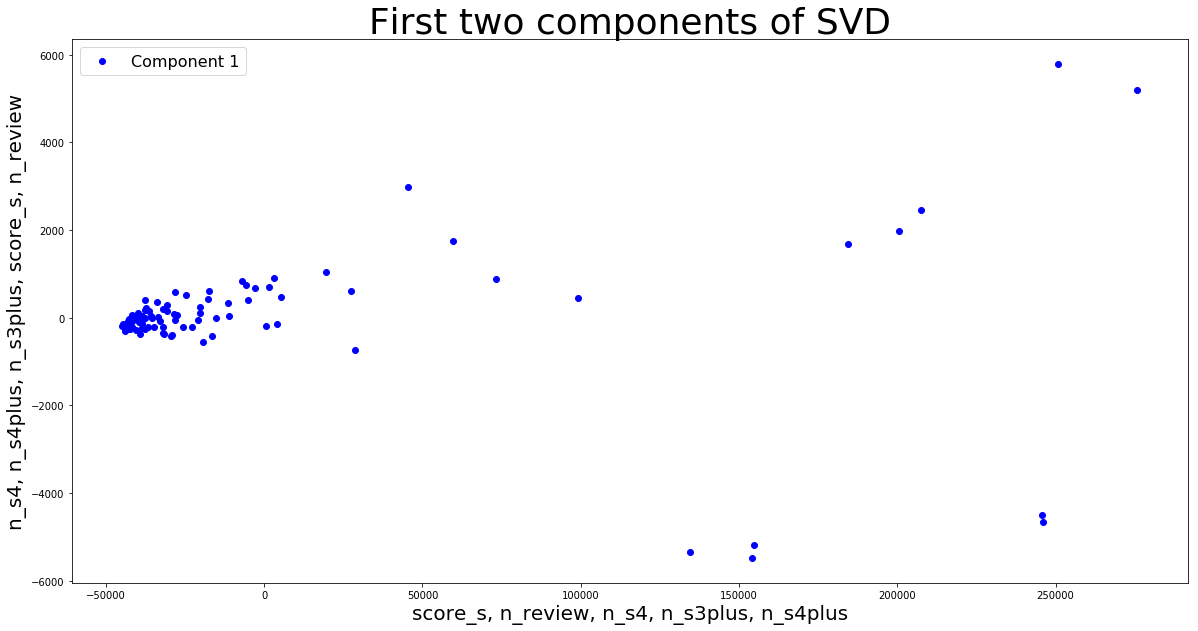

In [39]:
plt.figure(figsize=(20,10))
plt.scatter(svd_df.component_1, svd_df.component_2, c='blue')
plt.xlabel(f"{', '.join(loadings.sort_values('abs_component_1',ascending=False).head(5)[['component_1']].index)}",
          fontsize=20)
plt.ylabel(f"{', '.join(loadings.sort_values('abs_component_2',ascending=False).head(5)[['component_2']].index)}",
          fontsize=20)
plt.title('First two components of SVD', fontsize=36)
plt.legend(['Component 1', 'Component 2'], fontsize=16)

# Modeling with Principal Component Analysis

In [40]:
df_eval = pd.read_csv('../data/composite_zip_WI.csv')

In [41]:
X = df_eval.drop(['average_agi', 'zipcode'],axis=1)
y = df_eval['average_agi']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [43]:
ss = StandardScaler()
X_train = pd.DataFrame(ss.fit_transform(X_train))
X_test = pd.DataFrame(ss.transform(X_test))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
pca = PCA(n_components=1)
Z_train = pca.fit_transform(X_train)
Z_test = pca.transform(X_test)

In [45]:
# XGBoost parameters that will be gridsearched over
xgb_params = {
    'eta' : [0.1,0.3],
    'min_child_weight' : [1, 2, 3],
    'max_depth' : [3, 5 ,7, 9],
    'colsample_bytree' : [.5, .7, .9, 1]
}

# Initializing GridSearch over XGBoost
grid = GridSearchCV(
    XGBRegressor(),
    xgb_params,
    cv = 5,
    verbose = 1,
    return_train_score = True
)

# Fitting the model
grid.fit(Z_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    3.1s finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'eta': [0.1, 0.3], 'min_child_weight': [1, 2, 3], 'max_depth': [3, 5, 7, 9], 'colsample_bytree': [0.5, 0.7, 0.9, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [46]:
# The best_params_ attribute shows the highest scoring 
# hyperparameters that GridSearch found after fitting
grid.best_params_

{'colsample_bytree': 0.5, 'eta': 0.1, 'max_depth': 3, 'min_child_weight': 3}

In [47]:
# The best_score_ is the highest R2 score after fitting
# of all the hyperparameter combinations 
grid.best_score_

-0.9864647894662776

In [48]:
# Using the best parameters, I made a list of predictions to compare to the test split
y_hat = grid.predict(Z_test)

# Getting the RMSE of test split vs. predictions
rmse = round(mean_squared_error(y_test,y_hat) ** 0.5, 3)
print(rmse)

18277.824


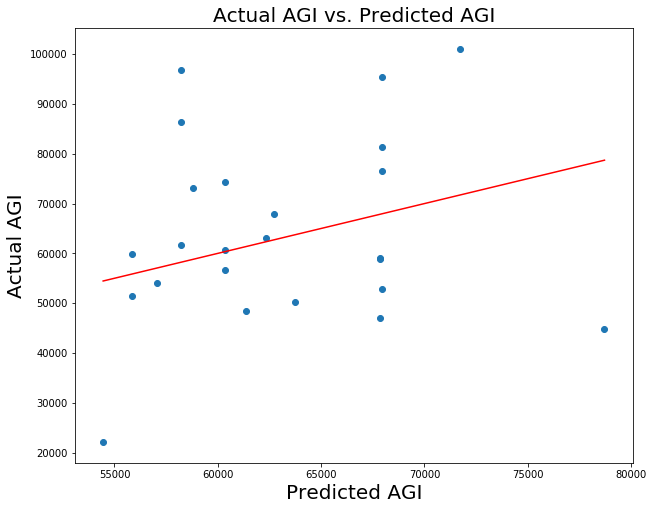

In [51]:
# Graphing true values vs. predicted values
plt.figure(figsize=(10,8), facecolor='w')
plt.title('Actual AGI vs. Predicted AGI', fontsize = 20)
plt.ylabel('Actual AGI', fontsize = 20)
plt.xlabel('Predicted AGI', fontsize = 20)
plt.plot(np.unique(y_hat), 
         np.unique(y_hat),
         color = 'red')
plt.scatter(y_hat, y_test);
# plt.savefig('../images/xgboost1.png', bbox_inches='tight')